This notebook aims to reproduce figure 7.6 in Wakeley's "Coalescent Theory: an Introduction". In order to do so, we will first load the function we need for calculating the rate matrix of the coalescent process:

In [1]:
from IPython.display import SVG
import numpy as np
import pandas as pd
%load_ext rpy2.ipython

In [2]:
def recombination(i):
    """
    This function returns all possible states after a 
    single recombination event given an initial state
    """
    # Create empty list
    new_lst = []
    # For each block index in the list
    for block in range(len(i)):
        # If the site is linked
        if 0 not in i[block]:
            # Remove block
            lst = i[:block]+i[block+1:]
            # Split block
            lst = lst + [(i[block][0], 0), (0, i[block][1])]
            # Append to list
            new_lst.append(sorted(lst))
    return new_lst

In [3]:
def coalescent(i):
    """
    This function returns all possible states after a 
    single coalescence event given an initial state. 
    The returned list is somewhat ordered, so that the 
    first states correspond to reversible coalescence 
    events, and the last to non-reversible ones.
    """
    # Get unique values per site
    n_0 = set([0]+list(sum(i, ())))
    reversible = []
    nonreversible = []
    # For each combination of blocks
    for b1 in range(len(i)):
        for b2 in range(b1+1, len(i)):
            # Create new block by merging
            add_lst = [(i[b1][0]+i[b2][0], i[b1][1]+i[b2][1])]
            # For each index in i
            for b3 in range(len(i)):
                # If the index is not in among the merged blocks
                if b3 not in [b1, b2]:
                    # Append to list
                    add_lst.append(i[b3])
            # If the unique values are different from the 
            # original block
            if set([0]+list(sum(add_lst, ()))) == n_0:
                # Append to reversible coalescence list
                reversible.append(sorted(add_lst))
            else:
                # Append to non-reversible coalescence list
                nonreversible.append(sorted(add_lst))
    l = reversible+nonreversible
    return l

In [4]:
def idx(i):
    j = list(sum(i, ()))
    return -(len(j)-j.count(0))

def get_states(lst):
    """
    Given a list of states, this function finds all possible
    recombination and coalescence states iteratively.
    """
    # Sort block per states just in case
    all_states = [sorted(i) for i in lst]
    # Define pool of states to be transformed
    state_pool = all_states
    # While the pool is non-empty
    while len(state_pool) > 0:
        # Define result list per iteration
        iter_states = []
        # For each of the states in the pool
        for i in state_pool:
            # Save coalescent transformation
            iter_states = iter_states+coalescent(i)
            # Save recombination transformation
            iter_states = iter_states+recombination(i)
        # Keep unique values in the original order
        iter_states = sorted(list(list(i) for i in set(tuple(row) for row in iter_states)), key = iter_states.index)
        # Define pool for next round
        state_pool = [i for i in iter_states if i not in all_states]
        # Add pool to overall list
        all_states += state_pool
        
    all_states = sorted(all_states, key = idx)
    return all_states

Starting in the situation where we have two genomes, each with two linked loci, we can obtain the full list of possible states:

In [5]:
state_2 = [[(1, 1), (2, 2), (4, 4)]]
iter_lst_2 = get_states(state_2)
len(iter_lst_2)

203

In [6]:
iter_lst_2[0:10]

[[(1, 1), (2, 2), (4, 4)],
 [(0, 1), (1, 0), (2, 2), (4, 4)],
 [(0, 2), (1, 1), (2, 0), (4, 4)],
 [(0, 4), (1, 1), (2, 2), (4, 0)],
 [(0, 1), (0, 2), (1, 0), (2, 0), (4, 4)],
 [(0, 1), (0, 4), (1, 0), (2, 2), (4, 0)],
 [(0, 2), (0, 4), (1, 1), (2, 0), (4, 0)],
 [(0, 2), (1, 0), (2, 1), (4, 4)],
 [(0, 1), (1, 2), (2, 0), (4, 4)],
 [(0, 1), (0, 2), (0, 4), (1, 0), (2, 0), (4, 0)]]

We can now calculate the transition rate matrix between the states, where `C` would correspond to the coalescence rate and `R` to the recombination rate:

In [7]:
def get_trans_mat(iter_lst_2, tht, rho):
    trans_mat_2 = np.full((len(iter_lst_2), len(iter_lst_2)), '0')
    for i in range(len(iter_lst_2)):
        new_lst = recombination(iter_lst_2[i])
        idx_lst = [iter_lst_2.index(j) for j in new_lst]
        for j in idx_lst:
            trans_mat_2[i,j]=rho
        new_lst = coalescent(iter_lst_2[i])
        idx_lst = [iter_lst_2.index(j) for j in new_lst]
        for j in idx_lst:
            trans_mat_2[i,j]=tht
        
    return pd.DataFrame(trans_mat_2)

In [8]:
trans_mat = get_trans_mat(iter_lst_2, 'C', 'R')
trans_mat

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,200,201,202
0,0,R,R,R,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C,0,0,0,R,R,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C,0,0,0,R,0,R,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C,0,0,0,0,R,R,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,C,C,0,0,0,0,C,C,R,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C
199,0,0,0,0,0,0,0,0,0,0,...,C,0,0,0,0,0,0,0,0,C
200,0,0,0,0,0,0,0,0,0,0,...,0,C,0,0,0,0,0,0,0,C
201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,R


We can now think about how to obtain the variance of the number of segregating ($\text{Var}[S]$) sites given $\theta$ and $\rho$. Following equation 7.20, Wakeley shows that $\text{Var}[S]$ is directly dependant on $\theta$ and the $\text{Cov}[T_i, T_j]$, which in turn depends on $\rho$. Wakeley provides an analytical formula for calculating $\text{Cov}[T_i, T_j]$ for a sample size of 2 (equation 7.17). However, we can apply phase-type theory to get the same result. We know that the number of segregating sites for each locus will depend on the genealogy that the sequences follow. As a result, we can generate a multivariate continuous phase-type distribution with two rewards, representing the time until the most recent common ancestor ($T_{\text{MRCA}}$) for the left site and the right site ($T_{\text{1}}$ and $T_{\text{2}}$ in the book, respectively). The rewards will be either 0 or 1 for each state, representing whether that site has already coalesced (0) or not (1). We can think of this as whether a certain state would contribute to generating segregating sites (1) or not (0). 

In [9]:
def get_reward_mat(iter_lst_2):
    
    # Create empty matrix
    trans_mat_2 = np.full((len(iter_lst_2), 2), 0.0)
    
    # For each state
    for i in range(len(iter_lst_2)):
        
        # Set accumulator
        acc = 3
        # For each genome
        for j in iter_lst_2[i]:
            # If the left allele exists
            if j[0] in [3, 5, 6, 7]:
                # Add 1 to accumulator
                acc = 0 if j[0] == 7 else 2
                break
        # Add a reward of 1 if there are 2 alleles
        trans_mat_2[i, 0] = acc
        
        # The same but for the right site
        acc = 3
        for j in iter_lst_2[i]:
            if j[1] in [3, 5, 6, 7]:
                acc = 0 if j[1] == 7 else 2
                break
        trans_mat_2[i, 1] = acc
        
    return trans_mat_2



#def get_reward_mat(iter_lst_2):
#    
#    # Create empty matrix
#    trans_mat_2 = np.full((len(iter_lst_2), 2), 0.0)
#    
#    # For each state
#    for i in range(len(iter_lst_2)):
#        
#        # Set accumulator to 0
#        acc = 1
#        # For each genome
#        for j in iter_lst_2[i]:
#            # If the left allele exists
#            if j[0] in [3, 5, 6, 7]:
#                # Add 1 to accumulator
#                acc = 0 if j[0] == 7 else 1
#                break
#        # Add a reward of 1 if there are 2 alleles
#        trans_mat_2[i, 0] = acc
#        
#        # The same but for the right site
#        acc = 1
#        for j in iter_lst_2[i]:
#            if j[1] in [3, 5, 6, 7]:
#                acc = 0 if j[1] == 7 else 1
#                break
#        trans_mat_2[i, 1] = acc
#        
#    return trans_mat_2

In [10]:
reward_mat = get_reward_mat(iter_lst_2)
reward_mat[190:203]

array([[0., 2.],
       [2., 0.],
       [0., 2.],
       [2., 0.],
       [0., 2.],
       [2., 0.],
       [0., 2.],
       [2., 0.],
       [0., 2.],
       [2., 0.],
       [0., 2.],
       [0., 0.],
       [0., 0.]])

Additionally, we can translate the generic transition rate matrix to one with the proper coalescent rate and recombination rate:

In [11]:
%%R -i reward_mat -i trans_mat

set_coa_rho <- function(X, coa, rho) {
    X[X == 'C'] <- coa
    X[X == 'R'] <- rho
    X = as.matrix(X)
    X <- matrix(as.numeric(X),    # Convert to numeric matrix
                  ncol = ncol(X))
    X[row(X)==col(X)] = -rowSums(X)
    X                                    # Print numeric matrix
}


In [12]:
%%R 

library(PhaseTypeR)
library(tidyverse)

R[write to console]: Loading required package: expm

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘expm’


R[write to console]: The following object is masked from ‘package:Matrix’:

    expm


R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union


R[write to console]: 
Attaching package: ‘PhaseTypeR’


R[write to console]: The following object is masked from ‘package:Matrix’:

    mean


R[write to console]: The following object is masked from ‘package:stats’:

    var


R[write to console]: The following object is masked from ‘package:base’:

    mean


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ 

We now have all the ingredients to get a multivariate continuous phase-type distribution. We should remember that phase-type distributions are defined by their sub-intensity matrix, that lacks the absorbing state. Thus, we will need to remove the last two states from our rate matrix and the reward matrix, and then we can use `PhaseTypeR` to create a MPH distribution and calculate its covariance $\text{Cov}[T_i, T_j]$:

In [25]:
%%R

coa = 1

Ttotal <- function(x) {
    rho = x/2
    mph <- MPH(
        set_coa_rho(trans_mat, coa, rho)[1:(nrow(trans_mat)-2),1:(nrow(trans_mat)-2)],
        c(1, rep(0, nrow(trans_mat)-3)), 
        reward_mat[1:(nrow(trans_mat)-2),]
    )
    mph
}

covar_Ttotal <- function(x) {
    var(Ttotal(x))[1, 2]
}

var_Ttotal <- function(x) {
    diag(var(Ttotal(x)))
}

mean_Ttotal <- function(x) {
    mean(Ttotal(x))
}






Tmrca <- function(x) {
    rho = x/2
    mph <- MPH(
        set_coa_rho(trans_mat, coa, rho)[1:(nrow(trans_mat)-2),1:(nrow(trans_mat)-2)],
        c(1, rep(0, nrow(trans_mat)-3)), 
        ifelse(reward_mat[1:(nrow(trans_mat)-2),] != 0, 1, 0)
    )
    mph
}

covar_Tmrca <- function(x) {
    var(Tmrca(x))[1, 2]
}

var_Tmrca <- function(x) {
    diag(var(Tmrca(x)))
}

mean_Tmrca <- function(x) {
    mean(Tmrca(x))
}


From 'Optimal Sequencing Strategies for Surveying Molecular Genetic Diversity' by Anna Pluzhnikov and Peter Donnelly (1996), we can use a recursion to calculate $\text{Cov}[T_{\text{total,1}\text{, }\text{total,2}}]$ for a sample size of n. However, I suspect that the recursion is incorrect, since it never converges:

In [26]:
%%R 

# fun_formula <- function(i1, i2, i3, R) {
#     Y1 = i1+i3
#     Y2 = i2+i3
#     K = i1+i2+i3
#     H = function(x) sum(1/(1:(x-1)))
#     
#     if (((i1+i3)<2) | ((i2+i3)<2)) {
#         return(0)
#     }
#     
#     if (((i1+i3)>4) | ((i2+i3)>4)) {
#         return(0)
#     }
#     
#     if (any(c(i1, i2, i3) < 0)) {
#         return(0)
#     }
#     
#     if (any(c(i1, i2, i3) > 2)) {
#         return(0)
#     }
#     
#     print(c(i1, i2, i3))
#     
#     Q1 = 2/(i3*R + K*(K-1))^2
#     Q2 = (1/(i3*R + K*(K-1))) * 
#          (
#              (i2*(i2-1) + i3*(i3-1) + 2*i2*i3)*H(Y2-1) +
#              (2*i1*i2 + i1*(i1-1) + 2*i3*i2 + i3*R)*H(Y2)
#          )
#     Q3 = (1/(i3*R + K*(K-1))) * 
#          (
#              (i1*(i1-1) + i3*(i3-1) + 2*i1*i3)*H(Y1-1) +
#              (2*i3*i2 + i2*(i2-1) + 2*i2*i1 + i3*R)*H(Y1)
#          )
#     
#     B1 = i1*(i1-1)*fun_formula(i1-1, i2, i3, R) +
#          i2*(i2-1)*fun_formula(i1, i2-1, i3, R) +
#          i3*(i3-1)*fun_formula(i1, i2, i3-1, R)
#     B2 = 2*(
#             i1*i2*fun_formula(i1-1, i2-1, i3+1, R) +
#             i1*i3*fun_formula(i1-1, i2, i3, R) +
#             i2*i3*fun_formula(i1, i2-1, i3, R)
#          )
#     B3 = i3*R*fun_formula(i1+1, i2+1, i3-1, R)
#     
#     Q4 = (1/(i3*R + K*(K-1))) * (B1+B2+B3)
#     
#     Q = Y1*Y2*Q1 + Y1*Q2 + Y2*Q3 + Q4
#     
#     return(Q)
#     
# }
# 
# fun_formula(2, 2, 0, 0.5)

NULL


Instead, we can use the formula provided for $\text{Cov}[T_{\text{MRCA,1}\text{, }\text{MRCA,2}}]$ by Hudson and Kaplan (STATISTICAL PROPERTIES OF THE NUMBER OF RECOMBINATION EVENTS IN THE HISTORY OF A SAMPLE OF DNA SEQUENCES) for when the recombination approaches 0. When this happens, the covariance for a sample size of 3 approaches 5/4 = 1.25:

In [27]:
%%R 

print(covar_Ttotal(0))  
print(var_Ttotal(0))    # Eq. 3.25
print(mean_Ttotal(0))   # Eq. 3.23
print(covar_Tmrca(0))
print(var_Tmrca(0))     # Eq. 3.26
print(mean_Tmrca(0))    # Eq. 3.24

[1] 5
[1] 5 5
[1] 3 3
[1] 1.111111
[1] 1.111111 1.111111
[1] 1.333333 1.333333


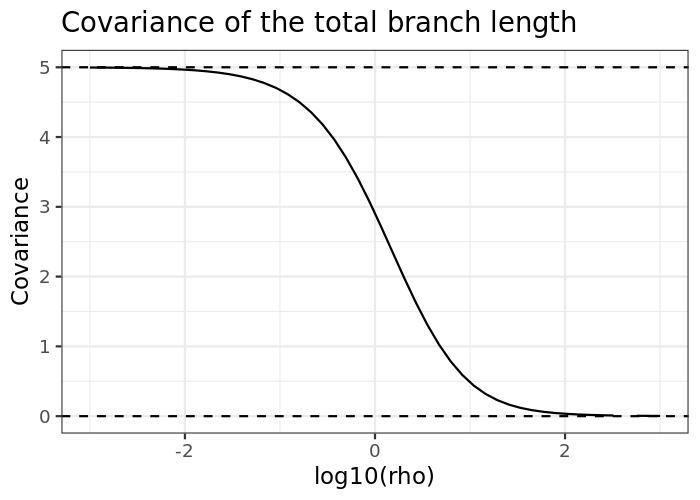

In [28]:
%%R  -w 700 -h 500 -r 150

# Create a logarithmic sequence
lseq <- function(from, to, length.out) {
  exp(seq(log(from), log(to), length.out = length.out))
}

covar_Ttotal_error <- function(x) {
    tryCatch(covar_Ttotal(x), error=function(e) NA)
}

rho_lst = lseq(0.001, 1000, length.out = 50)
phasetype_covar <- unlist(lapply(rho_lst, covar_Ttotal_error))

covar_tib <- tibble(
    rho = rho_lst,
    covar = phasetype_covar,
) 

covar_tib %>%
    ggplot() +
    geom_line(aes(log10(rho), covar)) +
    geom_hline(aes(yintercept = y), 
               linetype = 2,
               data = tibble(y = c(0, 5))) +
    theme_bw() +
    ylab('Covariance') +
    ggtitle('Covariance of the total branch length')

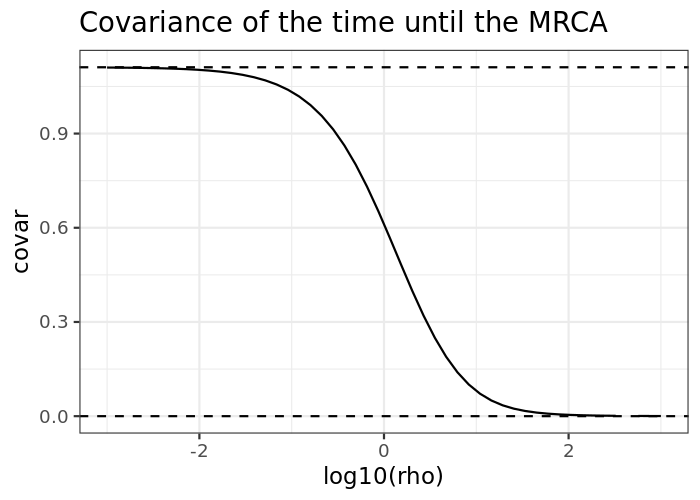

In [29]:
%%R  -w 700 -h 500 -r 150

# Create a logarithmic sequence
lseq <- function(from, to, length.out) {
  exp(seq(log(from), log(to), length.out = length.out))
}

covar_Tmrca_error <- function(x) {
    tryCatch(covar_Tmrca(x), error=function(e) NA)
}
var_Tmrca_error <- function(x) {
    tryCatch(var_Tmrca(x), error=function(e) NA)
}
mean_Tmrca_error <- function(x) {
    tryCatch(mean_Tmrca(x), error=function(e) NA)
}

rho_lst = lseq(0.001, 1000, length.out = 50)
phasetype_covar <- unlist(lapply(rho_lst, covar_Tmrca_error))

covar_tib <- tibble(
    rho = rho_lst,
    covar = phasetype_covar) 

covar_tib %>%
    ggplot() +
    geom_line(aes(log10(rho), covar)) +
    geom_hline(aes(yintercept = y), 
               linetype = 2,
               data = tibble(y = c(0, 10/9))) +
    theme_bw() +
    ggtitle('Covariance of the time until the MRCA')

We can see that when rho is very large, the covariance approaches 0, meaning that recombination would completely unlink the two loci. On the other hand, when rho is very small, then the loci will remain linked and will have the same genealogy.

We can now calculate the variance of the number of segregating sites for a sample size of 3. Instead of following equation 7.20 from Wakeley's book, we can use equation 8 from Hudson and Kaplan (1985):

In [30]:
%%R

# This function is what need to be integrated
covar_Tmrca_error_2 <- function(x, rho) {
    (rho-x)*covar_Tmrca(x)
}

# This performs the integral
integrate_covar <- function(rho) {
    integrate(Vectorize(covar_Tmrca_error_2), lower = 0, upper = rho, rho = rho)$value
}

# This returns Var_S or NA if there is an error
vec_fun_var <- function(rho) {
    tryCatch(tht*(3/2)+tht^2*(2/rho^2)*integrate_covar(rho), error=function(e) NA)
}


tht = 1
print(vec_fun_var(1e-16))
print(tht*(3/2)+tht^2*(5/4))

print(vec_fun_var(1e8))
print(tht)


rho_lst = lseq(0.001, 100000, length.out = 10)
var_lst = unlist(lapply(rho_lst, vec_fun_var))
var_tib = tibble(rho_lst = rho_lst, var_lst = var_lst)

[1] 2.611111
[1] 2.75
[1] NA
[1] 1


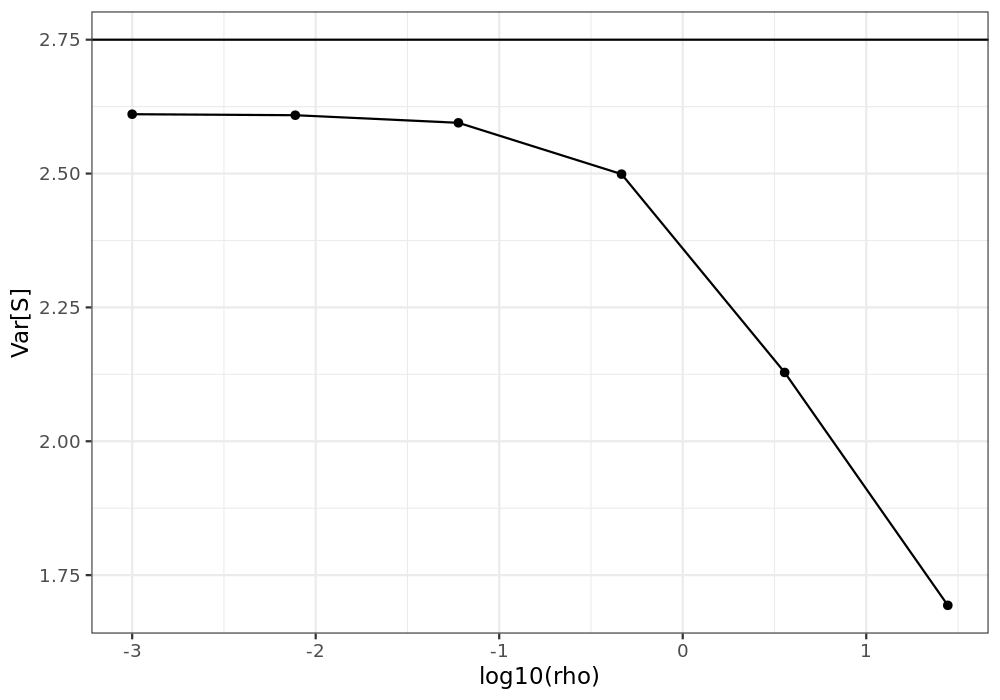

In [54]:
%%R -w 1000 -h 700 -r 150

var_tib %>% 
    drop_na() %>% 
    ggplot() +
    geom_point(aes(log10(rho_lst), var_lst)) +
    geom_line(aes(log10(rho_lst), var_lst)) +
    geom_hline(aes(yintercept = tht*(3/2)+tht^2*(5/4))) +
    theme_bw() +
    ylab('Var[S]') +
    xlab('log10(rho)')

In [14]:
%%R


lseq <- function(from, to, length.out) {
  exp(seq(log(from), log(to), length.out = length.out))
}

# This function is what need to be integrated
covar_Tmrca_error_2 <- function(x, rho) {
    (rho-x)*covar_Tmrca(x)
}

# This performs the integral
integrate_covar <- function(rho) {
    integrate(Vectorize(covar_Tmrca_error_2), lower = 0, upper = rho, rho = rho)$value
}

# This returns Var_S or NA if there is an error
vec_fun_var <- function(rho) {
    tht*(3/2)+tht^2*(2/rho^2)*integrate_covar(rho)
}


tht = 1


for (i in lseq(0.001, 1000, length.out = 10)) {
    covar_Tmrca(i)
}


i


R[write to console]: Error in MPH(set_coa_rho(trans_mat, coa, rho)[1:(nrow(trans_mat) - 2),  : 
  The row sums of the subintensity matrix should be non-positive.




Error in MPH(set_coa_rho(trans_mat, coa, rho)[1:(nrow(trans_mat) - 2),  : 
  The row sums of the subintensity matrix should be non-positive.


RInterpreterError: Failed to parse and evaluate line '\n\nlseq <- function(from, to, length.out) {\n  exp(seq(log(from), log(to), length.out = length.out))\n}\n\n# This function is what need to be integrated\ncovar_Tmrca_error_2 <- function(x, rho) {\n    (rho-x)*covar_Tmrca(x)\n}\n\n# This performs the integral\nintegrate_covar <- function(rho) {\n    integrate(Vectorize(covar_Tmrca_error_2), lower = 0, upper = rho, rho = rho)$value\n}\n\n# This returns Var_S or NA if there is an error\nvec_fun_var <- function(rho) {\n    tht*(3/2)+tht^2*(2/rho^2)*integrate_covar(rho)\n}\n\n\ntht = 1\n\n\nfor (i in lseq(0.001, 1000, length.out = 10)) {\n    covar_Tmrca(i)\n}\n\n\ni\n'.
R error message: 'Error in MPH(set_coa_rho(trans_mat, coa, rho)[1:(nrow(trans_mat) - 2),  : \n  The row sums of the subintensity matrix should be non-positive.'

In [34]:
%%R


Tmrca <- function(x) {
    rho = x/2
    
    print(rowSums(set_coa_rho(trans_mat, coa, rho)[1:(nrow(trans_mat)-2),1:(nrow(trans_mat)-2)]))
    mph <- MPH(
        set_coa_rho(trans_mat, coa, rho)[1:(nrow(trans_mat)-2),1:(nrow(trans_mat)-2)],
        c(1, rep(0, nrow(trans_mat)-3)), 
        ifelse(reward_mat[1:(nrow(trans_mat)-2),] != 0, 1, 0)
    )
    mph
}

covar_Tmrca <- function(x) {
    var(Tmrca(x))[1, 2]
}


covar_Tmrca(215.4435)

  [1] -1.421085e-14  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
  [6]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [11]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -1.421085e-14
 [16]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [21]  0.000000e+00 -1.421085e-14 -1.421085e-14  0.000000e+00  0.000000e+00
 [26]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [31]  0.000000e+00  0.000000e+00 -1.421085e-14 -1.421085e-14  0.000000e+00
 [36]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [41]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [46]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [51]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [56]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [61]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [66]  0.000

In [35]:
%%R

covar_Tmrca(i)

  [1]  2.842171e-14  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
  [6]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [11]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.842171e-14
 [16]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [21]  0.000000e+00  2.842171e-14  2.842171e-14  0.000000e+00  0.000000e+00
 [26]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [31]  0.000000e+00  0.000000e+00  2.842171e-14  2.842171e-14  0.000000e+00
 [36]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [41]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [46]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [51]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [56]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [61]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [66]  0.000

R[write to console]: Error in MPH(set_coa_rho(trans_mat, coa, rho)[1:(nrow(trans_mat) - 2),  : 
  The row sums of the subintensity matrix should be non-positive.




Error in MPH(set_coa_rho(trans_mat, coa, rho)[1:(nrow(trans_mat) - 2),  : 
  The row sums of the subintensity matrix should be non-positive.


RInterpreterError: Failed to parse and evaluate line '\ncovar_Tmrca(i)\n'.
R error message: 'Error in MPH(set_coa_rho(trans_mat, coa, rho)[1:(nrow(trans_mat) - 2),  : \n  The row sums of the subintensity matrix should be non-positive.'